<a href="https://colab.research.google.com/github/GamelinAl/mbtrack2_examples/blob/main/mbtrack2_BxB_FB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bunch-by-bunch damper feedback

This notebook introduces the ``ExponentialDamper`` and ``FIRDamper`` classes for **mbtrack2**:

*   The ``ExponentialDamper`` is a very simple bunch-by-bunch damper feedback class based on exponential damping.
*   The ``FIRDamper`` is a more realistic bunch-by-bunch damper feedback class based on FIR filters.


# Installation

In [4]:
! git clone -b develop https://gitlab.synchrotron-soleil.fr/PA/collective-effects/mbtrack2.git

Cloning into 'mbtrack2'...
remote: Enumerating objects: 1526, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 1526 (delta 118), reused 0 (delta 0), pack-reused 1340
Receiving objects: 100% (1526/1526), 709.26 KiB | 1024.00 KiB/s, done.
Resolving deltas: 100% (1047/1047), done.


In [5]:
%cd mbtrack2

/content/mbtrack2


# Tracking set-up

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as hp
from mbtrack2.tracking import Synchrotron, Electron
from mbtrack2.utilities import Optics
from mbtrack2.tracking import Bunch
from mbtrack2.tracking import LongitudinalMap, RFCavity, SynchrotronRadiation, TransverseMap

In [7]:
h = 20 # Harmonic number of the accelerator.
L = 100 # Ring circumference in [m].
E0 = 1.5e9 # Nominal (total) energy of the ring in [eV].
particle = Electron() # Particle considered.
ac = 1e-3 # Momentum compaction factor.
U0 = 200e3 # Energy loss per turn in [eV].
tau = np.array([1e-3, 1e-3, 2e-3]) # Horizontal, vertical and longitudinal damping times in [s].
tune = np.array([12.2, 15.3]) # Horizontal and vertical tunes.
emit = np.array([10e-9, 10e-12]) # Horizontal and vertical equilibrium emittance in [m.rad].
sigma_0 = 15e-12 # Natural bunch length in [s].
sigma_delta = 1e-3 # Equilibrium energy spread.
chro = [2.0, 3.0] # Horizontal and vertical (non-normalized) chromaticities.

local_beta = np.array([3, 2]) # Beta function at the tracking location.
local_alpha = np.array([0, 0]) # Alpha function at the tracking location.
local_dispersion = np.array([0, 0, 0, 0]) # Dispersion function and its derivative at the tracking location.
optics = Optics(local_beta=local_beta, local_alpha=local_alpha, 
                  local_dispersion=local_dispersion)

ring = Synchrotron(h=h, optics=optics, particle=particle, L=L, E0=E0, ac=ac, 
                   U0=U0, tau=tau, emit=emit, tune=tune, 
                   sigma_delta=sigma_delta, sigma_0=sigma_0, chro=chro)

In [8]:
LongMap = LongitudinalMap(ring)
RF = RFCavity(ring, m=1, Vc=1e6, theta=np.arccos(ring.U0/1e6))
SR = SynchrotronRadiation(ring)
TransMap = TransverseMap(ring)

# ExponentialDamper

In [9]:
from mbtrack2 import ExponentialDamper, BunchMonitor

Initialize a single particle with a 1 mm horizontal offset

In [10]:
mybunch = Bunch(ring, mp_number=1, current=1e-3)
mybunch["x"] += 1e-3

Initialize an ``ExponentialDamper`` in the horizontal plane with a damping time of 50 turns and a phase of 90° (fully resistive damper).

In [11]:
damper = ExponentialDamper(ring=ring, plane="x", damping_time=ring.T0*50, phase_diff=np.pi/2)

In [12]:
bunchmon = BunchMonitor(bunch_number=0, save_every=1, buffer_size=10, total_size=1000, file_name="damper")

turns = 1000
for i in range(turns):
  LongMap.track(mybunch)
  TransMap.track(mybunch)
  RF.track(mybunch)
  damper.track(mybunch)
  bunchmon.track(mybunch)
bunchmon.close()

Plot the particle position and Courant-Snyder invariant:

In [13]:
from mbtrack2 import plot_bunchdata

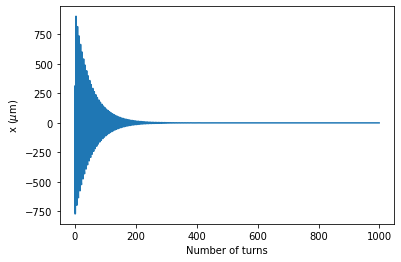

In [14]:
fig = plot_bunchdata("damper.hdf5",0,"mean","x")

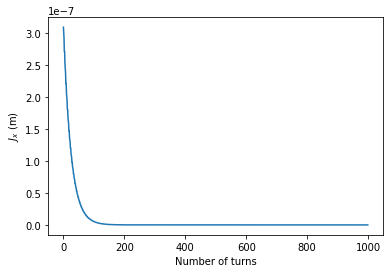

In [15]:
fig = plot_bunchdata("damper.hdf5",0,"cs_invariant","x")

Compute the damping time from tracking data in turn number:

In [16]:
from scipy.optimize import curve_fit

In [17]:
g = hp.File("damper.hdf5","r")
xdata = np.array(g["BunchData_0"]["time"])*ring.T0
ydata = np.array(g["BunchData_0"]["cs_invariant"][0,:])
g.close()

In [18]:
def func(x, a, b):
    return a * np.exp(-b * x)

Fitted damping time is 49.06419715200237 turns.
Input damping time is 50.0 turns.


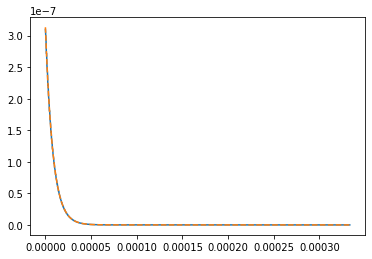

In [28]:
popt, pcov = curve_fit(func, xdata, ydata)
print(f"Fitted damping time is {1/popt[1]/ring.T0*2} turns.")
print(f"Input damping time is {damper.damping_time/ring.T0} turns.")
plt.plot(xdata, ydata)
plt.plot(xdata, func(xdata, *popt),"--")

# FIRDamper 

In [29]:
from mbtrack2 import FIRDamper 

## Stable case (low gain)

In [30]:
mybunch = Bunch(ring, mp_number=1, current=1e-3, track_alive=False)
mybunch["x"] += 1e-3

Initialize a ``FIRDamper`` element on the horizontal plane.

The FIR filter is computed for a reference tune of 0.2 (usually the same as ``ring.tune``) with a gain of 0.1 and a phase of -90°. A delay of 1 turn between the measurement and the kick is also taken into account.

If the gain is low enough, the ``FIRDamper`` element should provide damping.

In [31]:
fir_damp = FIRDamper(ring=ring, plane="x", tune=0.2, turn_delay=1, tap_number=5, 
                     gain=0.1, phase=-90, bpm_error=None, max_kick=None)

The FIR filter computed from the input can then be plotted:

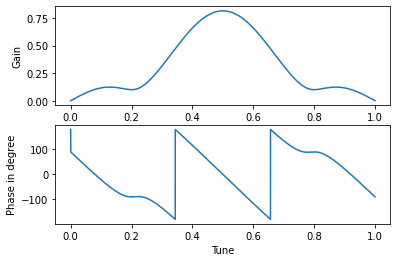

In [32]:
fig = fir_damp.plot_fir()

In [33]:
bunchmon = BunchMonitor(bunch_number=0, save_every=1, buffer_size=10, total_size=100, file_name="fir")

turns = 100
for i in range(turns):
  LongMap.track(mybunch)
  TransMap.track(mybunch)
  RF.track(mybunch)
  fir_damp.track(mybunch)
  bunchmon.track(mybunch)
bunchmon.close()

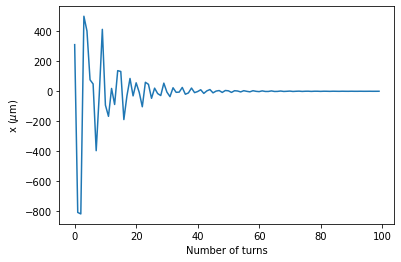

In [36]:
fig = plot_bunchdata("fir.hdf5",0,"mean","x")

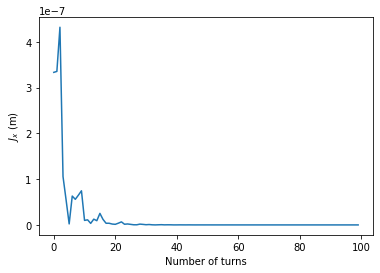

In [37]:
fig = plot_bunchdata("fir.hdf5",0,"cs_invariant","x")

In [38]:
g = hp.File("fir.hdf5","r")
xdata = np.array(g["BunchData_0"]["time"])*ring.T0
ydata = np.array(g["BunchData_0"]["cs_invariant"][0,:])
g.close()

In [39]:
def func(x, a, b):
    return a * np.exp(-b * x)

Fitted damping time is 6.990584491546427 turns.


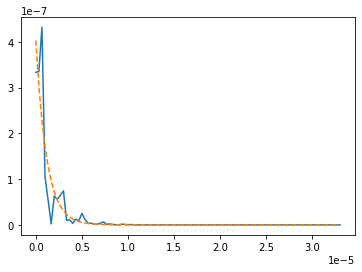

In [41]:
popt, pcov = curve_fit(func, xdata, ydata)
print(f"Fitted damping time is {1/popt[1]/ring.T0*2} turns.")
plt.plot(xdata, ydata)
plt.plot(xdata, func(xdata, *popt),"--")

## Unstable case (high gain)

In [42]:
mybunch = Bunch(ring, mp_number=1, current=1e-3, track_alive=False)
mybunch["x"] += 1e-3

If the gain is too high (here gain = 0.5 is enough), the ``FIRDamper`` leads to unstable dynamics.

In [43]:
fir_damp = FIRDamper(ring=ring, plane="x", tune=0.2, turn_delay=1, tap_number=5, 
                     gain=0.5, phase=-90, bpm_error=None, max_kick=None)

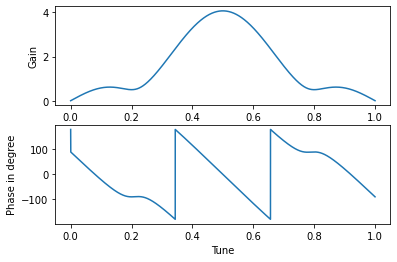

In [44]:
fig = fir_damp.plot_fir()

In [45]:
bunchmon = BunchMonitor(bunch_number=0, save_every=1, buffer_size=10, total_size=100, file_name="fir")

turns = 100
for i in range(turns):
  LongMap.track(mybunch)
  TransMap.track(mybunch)
  RF.track(mybunch)
  fir_damp.track(mybunch)
  bunchmon.track(mybunch)
bunchmon.close()

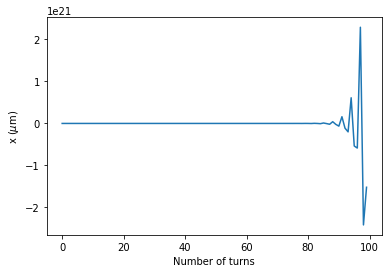

In [46]:
fig = plot_bunchdata("fir.hdf5",0,"mean","x")

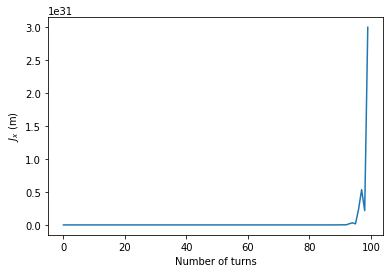

In [47]:
fig = plot_bunchdata("fir.hdf5",0,"cs_invariant","x")

## Physical limitations

Physical limitations such as the maximum kick strength or the BPM measurement errors can possibly change the damping time.

### Maximum kick limit

In [64]:
mybunch = Bunch(ring, mp_number=1, current=1e-3, track_alive=False)
mybunch["x"] += 1e-3

Here the ``max_kick`` of the ``FIRDamper`` is set to 0.1 mrad:

In [65]:
fir_damp = FIRDamper(ring=ring, plane="x", tune=0.2, turn_delay=1, tap_number=5, 
                     gain=0.1, phase=-90, bpm_error=None, max_kick=0.1e-3)

In [66]:
bunchmon = BunchMonitor(bunch_number=0, save_every=1, buffer_size=10, total_size=100, file_name="fir")

turns = 100
for i in range(turns):
  LongMap.track(mybunch)
  TransMap.track(mybunch)
  RF.track(mybunch)
  fir_damp.track(mybunch)
  bunchmon.track(mybunch)
bunchmon.close()

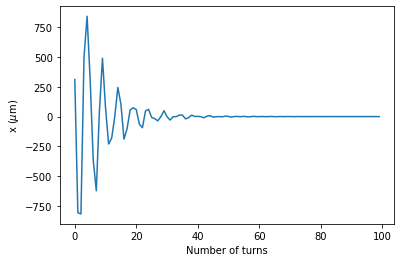

In [67]:
fig = plot_bunchdata("fir.hdf5",0,"mean","x")

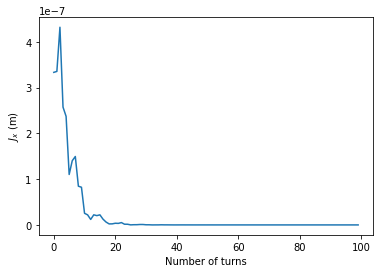

In [68]:
fig = plot_bunchdata("fir.hdf5",0,"cs_invariant","x")

In [69]:
g = hp.File("fir.hdf5","r")
xdata = np.array(g["BunchData_0"]["time"])*ring.T0
ydata = np.array(g["BunchData_0"]["cs_invariant"][0,:])
g.close()

In [70]:
def func(x, a, b):
    return a * np.exp(-b * x)

The damping time is increased from 7 turns to 11 turns due to the kick strength limitation.

Fitted damping time is 10.853769514931573 turns.


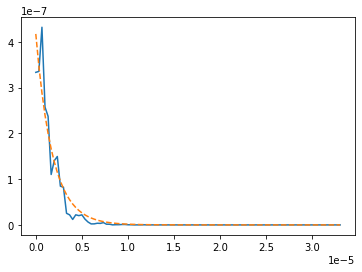

In [71]:
popt, pcov = curve_fit(func, xdata, ydata)
print(f"Fitted damping time is {1/popt[1]/ring.T0*2} turns.")
plt.plot(xdata, ydata)
plt.plot(xdata, func(xdata, *popt),"--")

### BPM measurement error

In [102]:
mybunch = Bunch(ring, mp_number=1, current=1e-3, track_alive=False)
mybunch["x"] += 1e-3

Here a random measurement error of 50 um RMS is added to the bunch mean position used for the feedback correction.

In [103]:
fir_damp = FIRDamper(ring=ring, plane="x", tune=0.2, turn_delay=1, tap_number=5, 
                     gain=0.1, phase=-90, bpm_error=50e-6, max_kick=None)

In [104]:
bunchmon = BunchMonitor(bunch_number=0, save_every=1, buffer_size=10, total_size=100, file_name="fir")

turns = 100
for i in range(turns):
  LongMap.track(mybunch)
  TransMap.track(mybunch)
  RF.track(mybunch)
  fir_damp.track(mybunch)
  bunchmon.track(mybunch)
bunchmon.close()

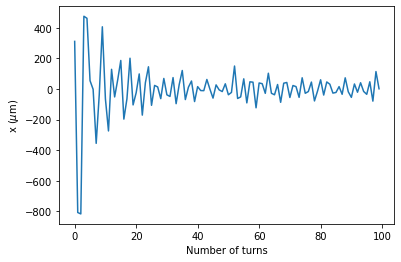

In [105]:
fig = plot_bunchdata("fir.hdf5",0,"mean","x")

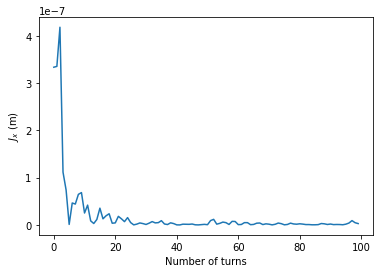

In [106]:
fig = plot_bunchdata("fir.hdf5",0,"cs_invariant","x")

In [107]:
g = hp.File("fir.hdf5","r")
xdata = np.array(g["BunchData_0"]["time"])*ring.T0
ydata = np.array(g["BunchData_0"]["cs_invariant"][0,:])
g.close()

In [108]:
def func(x, a, b):
    return a * np.exp(-b * x)

Fitted damping time is 7.119675249743109 turns.


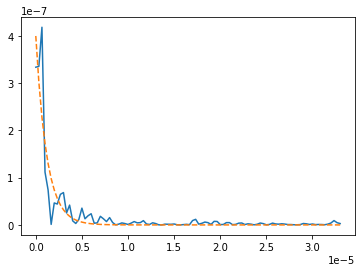

In [109]:
popt, pcov = curve_fit(func, xdata, ydata)
print(f"Fitted damping time is {1/popt[1]/ring.T0*2} turns.")
plt.plot(xdata, ydata)
plt.plot(xdata, func(xdata, *popt),"--")